# Tutorial 2: Forest Fires with Terrain and Vegetation Type

In tutorial 1, we explored basic cellular automata models and probabilistic cellular automata models for simulating fire spread. In this tutorial, we will explore the effect of two factors that contribute to how fires spread: vegetation type and terrain.



First, we'll rewrite some of the basics from the first tutorial to set up our model.

In [1]:
import numpy as np
import scipy as sp
import scipy.sparse
import matplotlib as mpl
import matplotlib.pyplot as plt

empty = 0
unburned = 1
burning = 2 
burned = 3

In [2]:
def create_world(n, q):
    world = np.zeros((n+2, n+2))
    forest = world[1:-1, 1:-1]
    forest[:, :] = np.random.choice([0, 1], p=[1-q, q], size=(n, n))
    return world

def show_world(W, title=None, **args):
    if 'cmap' not in args:
        args['cmap'] = 'jet'
    if 'vmin' not in args and 'vmax' not in args:
        args['vmin'] = 0
        args['vmax'] = 3
    plt.figure(figsize=(8, 8))
    plt.matshow(W, fignum=1, **args)
    plt.xlabel('column')
    plt.ylabel('row')
    plt.colorbar()
    if title is None:
        num_trees = (W > 0).sum()
        if num_trees > 0:
            num_burnt = (W == 3).sum()
            percent = num_burnt / num_trees * 1e2
            title = '{} / {} ~= {:.1f}%'.format(num_burnt, num_trees, percent)
        else:
            title = ''
    plt.title(title)
    pass

def is_empty(W):
    return W == empty

def is_vegetation(W):
    return W > empty

def is_unburned(W):
    return W == 1

def is_burning(W):
    return W == 2

def is_burned(W):
    return W == 3

def count(W, cond_fun):
    return cond_fun(W).sum()

def summarize_world(W):
    def suffix(n):
        return (1, "tree") if n == 1 else (n, "trees")
    m, n = W.shape[0]-2, W.shape[1]-2
    n_trees = count(W, is_vegetation)
    n_unburned = count(W, is_unburned)
    n_burning = count(W, is_burning)
    n_burned = count(W, is_burned)
    
    print("The world has dimensions: {} x {}".format(m, n))
    print("There are {} cell(s) that have had vegetation in them".format(n_trees))
    print("There are {} cell(s) of vegetation that are unburned".format(n_unburned))
    print("There are {} cell(s) of vegetation on fire".format(n_burning))
    print("There are {} cell(s) of vegetation completely burned".format(n_burned))

def start_fire(W, cells=None):
    W_new = W.copy()
    
    if cells == None:
        F = W[1:-1, 1:-1]
        W_new = W.copy()
        F_new = W_new[1:-1, 1:-1]
        I, J = np.where(is_unburned(F)) # Positions of all trees
        if len(I) > 0:
            k = np.random.choice(range(len(I))) # Index of tree to ignite
            i, j = I[k], J[k]
            assert F_new[i, j] == 1, "Attempting to ignite a non-tree?"
            F_new[i, j] += 1
    else:
        W_new = W.copy()
        
        for x,y in cells:
            W_new[x,y] = 2
    
    return W_new


## Forest Type

Different types of forest have different propensities for fire spreading. According to "A cellular automata model for forest fire spreading simulation" by Xuehua et al (see Citations.txt in this directory for full citation), we can formulate forests as one of three types: coniferous, broadleaf, or mixed. 

Coniferous forests have the lowest water content and thus burn the fastest; broadleaf forests have higher water contents and thus burn slower. We can formulate these differences with the following probabilities of spread.

- Coniferous: .9
- Broadleaf: .7

These probabilities could be adjusted with more empircal data from actual forest fires, but were artificially created here to illustrate the differences in forest type.

In the funciton below called `create_transition_matrix` we will create a matrix with probabilities for each cell depending on the tree type. If the forest is of mixed type, we randomly put either the Coniferous or Broadleaf probability in cells. This matrix will be cross-referenced with the cells that have vegetation in the spread function later. 

In [3]:
def create_transition_matrix(world, tree_type):
    if tree_type not in ['C', 'B', 'M']:
        raise ValueError('Tree type must be coniferous (\'C\'), Broadleaf (\'B\'), or mixed (\'M\')')
    
    probs = {'C': .9, 'B': .7}
    
    mat = np.ones(world.shape)
    
    if tree_type is 'M':
        mat = np.random.rand(*world.shape)
        
        c_index = mat < .5
        b_index = mat >= .5
        
        mat[c_index] = probs['C']
        mat[b_index] = probs['B']
        
    else:
        mat *= probs[tree_type]
    
    return mat
    

This function lets us visualize our transition matrix.

In [4]:
def show_tm(W, title=None, **args):
    if 'cmap' not in args:
        args['cmap'] = 'terrain'
    if 'vmin' not in args and 'vmax' not in args:
        args['vmin'] = 0
        args['vmax'] = 1
    plt.figure(figsize=(8, 8))
    plt.matshow(W, fignum=1, **args)
    plt.xlabel('column')
    plt.ylabel('row')
    plt.colorbar()
    
    title = 'Types of trees (darker are more likely to burn)'
    
    plt.title(title)
    pass

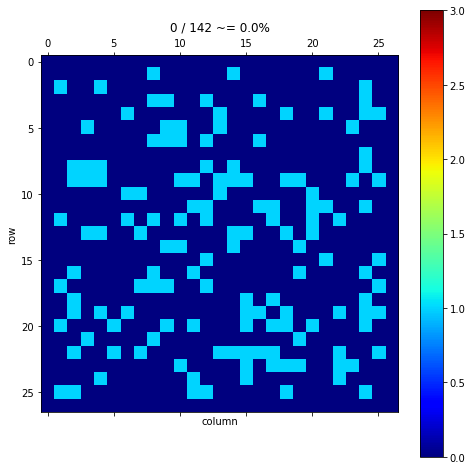

In [5]:
World = create_world(25, 0.25)
show_world(World)

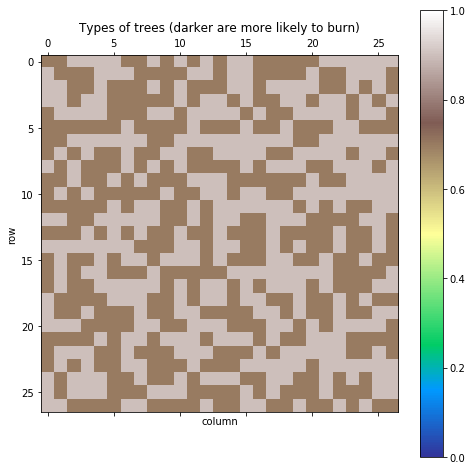

In [6]:
tm = create_transition_matrix(World, 'M')
show_tm(tm)

We can also visualize the transition matrix only where trees are present as below to get a more accurate picture.

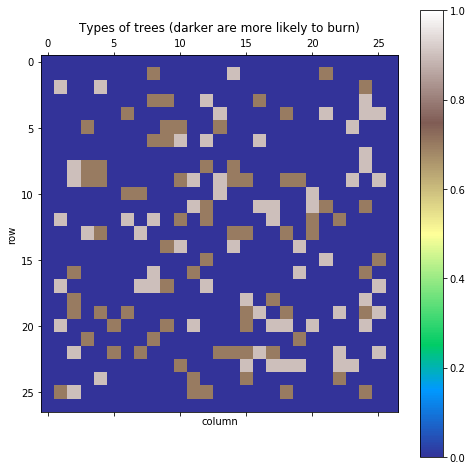

In [7]:
veg = is_vegetation(World)

tm_tree = np.multiply(tm, veg)

show_tm(tm_tree)

### Probabilistic Spreading with forest type

Building off our earlier probabilistic model, we can edit our spread fire funciton to take the type of forest into account

In [8]:
def spread_fire_forest_type(W, transition_matrix):
    W_new = W.copy()
    Vegetation = is_unburned(W)
    Fires = is_burning(W)
    
    num_neighbors_on_fire = (Fires[:-2, :-2].astype(int) + Fires[1:-1, :-2] + Fires[2:, :-2] 
                             + Fires[:-2, 1:-1]                             + Fires[2:, 1:-1] 
                             + Fires[:-2, 2:]            + Fires[1:-1, 2:]  + Fires[2:, 2:])
  
    num_neighbors_on_fire = np.multiply(num_neighbors_on_fire, Vegetation[1:-1, 1:-1].astype(int))
    
    # Here, we take into account the transition probabilities at each cell 
    fire_prob_matrix = np.ones(num_neighbors_on_fire.shape) - transition_matrix[1:-1, 1:-1]
    
    fire_prob_matrix = 1.0 - np.power(fire_prob_matrix, num_neighbors_on_fire)
    
    # As before, we only look at the cells where trees actually exist
    fire_prob_matrix = np.multiply(fire_prob_matrix, Vegetation[1:-1, 1:-1].astype(int))
    
    randys = np.random.rand(*fire_prob_matrix.shape)
    new_on_fires = randys < fire_prob_matrix
    
    W_new[1:-1, 1:-1] += new_on_fires
 
    W_new[1:-1, 1:-1] += Fires[1:-1, 1:-1]

    return W_new


Below, an example using our new spread funciton.
   

The world has dimensions: 20 x 20
There are 400 cell(s) that have had vegetation in them
There are 399 cell(s) of vegetation that are unburned
There are 1 cell(s) of vegetation on fire
There are 0 cell(s) of vegetation completely burned


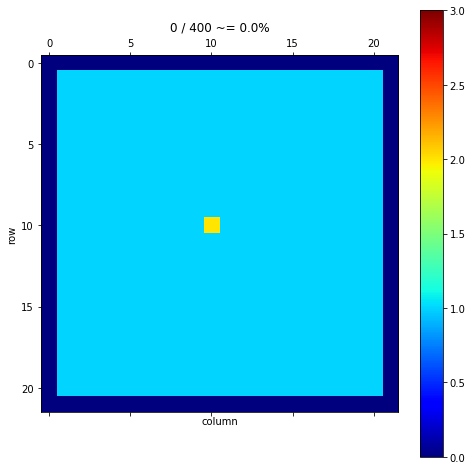

In [12]:
World = create_world(20, 1)
tm = create_transition_matrix(World, 'M')
World_next = start_fire(World, [(10,10)])
show_world(World_next)
summarize_world(World_next)

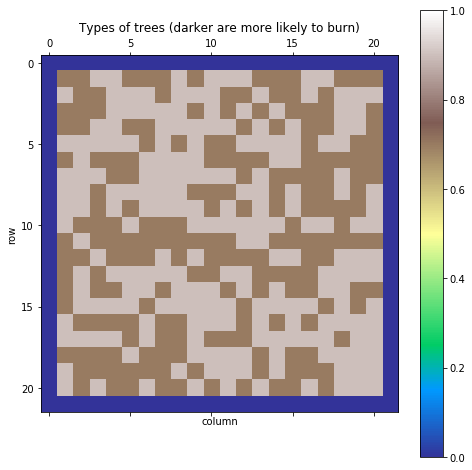

In [13]:
show_tm(np.multiply(tm, is_vegetation(World)))

The world has dimensions: 20 x 20
There are 400 cell(s) that have had vegetation in them
There are 392 cell(s) of vegetation that are unburned
There are 7 cell(s) of vegetation on fire
There are 1 cell(s) of vegetation completely burned


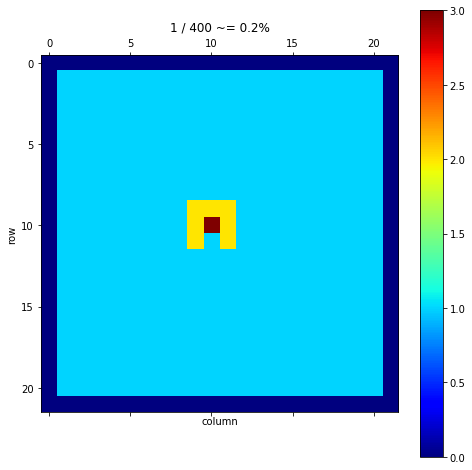

In [14]:
# Second Timestep
World_next = spread_fire_forest_type(World_next, tm)
show_world(World_next)
summarize_world(World_next)

## Terrain

In addition to forest types, the elevation in a forest can impact the spread of fire. If a central cell is higher than surrounding cells, then the angle between the flames and the fuel will cause the fire to spead faster. We can model this phenomenon as below.


First, we'll create some functions to add elevations to a world.

In [15]:
# create random elevations between 0 and 10 
def create_random_elevations(world):
    elevs = np.random.randint(0, 10, size=world.shape)
    
    return elevs
    
# add ridge of elevation 10 down the middle of the map
def add_middle_ridge(elevs):
    
    elevs[:, elevs.shape[1]//2] = 10
    
    return elevs

# create a map with 0 elevation on one half and increasing on the other
def create_increasing_elevations(world):
    elevs = np.zeros(world.shape)
    num_tiers = elevs.shape[1]//2
        
    tiers = np.linspace(1, num_tiers, num_tiers)
    
    r = num_tiers
    
    if elevs.shape[1] % 2:
        r += 1
    
    for i in range(1, r):
        elevs[:, num_tiers + i] = np.full((1, elevs.shape[0]), i)
    
    return elevs
    
def show_elevs(elevs, title=None, **args):
    if 'cmap' not in args:
        args['cmap'] = 'terrain'
    if 'vmin' not in args and 'vmax' not in args:
        args['vmin'] = 0
        args['vmax'] = np.max(elevs)
    plt.figure(figsize=(8, 8))
    plt.matshow(elevs, fignum=1, **args)
    plt.xlabel('column')
    plt.ylabel('row')
    plt.colorbar()
    
    title = 'Elevation'
    
    plt.title(title)
    pass
    

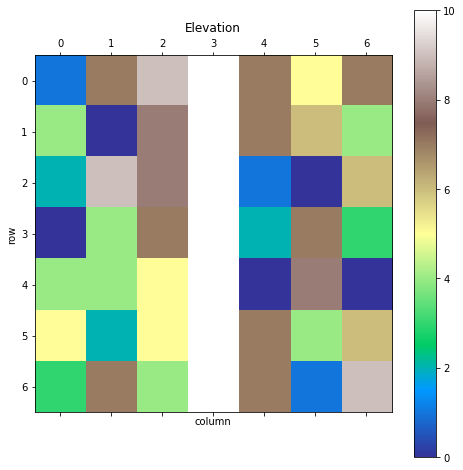

In [16]:
w = create_world(5, 1)
e = create_random_elevations(w)
e = add_middle_ridge(e)

show_elevs(e)


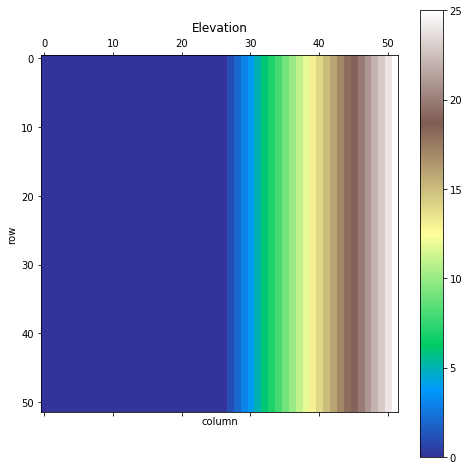

In [17]:
w = create_world(50, 1)
e = create_increasing_elevations(w)

show_elevs(e)

To actually see how a cell compares to its neighbors, we'll use the gradient to approximate how a cell compares to its neighbors. We can look at the gradient in both the row-wise and column-wise directions to determine how a cell compares to its N, E, S, W neighbors and then shift this gradient to center the values on the cell rather than its neighbors.

In [18]:
def elev_transition_prob(elevs_mat):    
    vert, row = np.gradient(elevs_mat)
    
    c0 = np.roll(row, 1, axis=1)
    c0[:, 0] = 0
    
    c1 = np.roll(vert, 1, axis=0)
    c1[0, :] = 0
    
    c = np.maximum(c0, c1)   
    
    diff = c.max() - c.min()
    if not diff: diff = 1

    c = (c - c.min()) / diff
        
    return c
    

In [19]:
w = create_world(15, 1)
e = create_increasing_elevations(w)

# e = np.matrix([[0,0,0,0,0],
#              [0,0,0,0,0],
#              [0,0,0,0,0],
#              [0,0,0,0,0],
#              [0,0,0,0,0]])

t = elev_transition_prob(e)

In [20]:
t

array([[0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.5, 1. , 1. , 1. ,
        1. , 1. , 1. , 1. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.5, 1. , 1. , 1. ,
        1. , 1. , 1. , 1. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.5, 1. , 1. , 1. ,
        1. , 1. , 1. , 1. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.5, 1. , 1. , 1. ,
        1. , 1. , 1. , 1. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.5, 1. , 1. , 1. ,
        1. , 1. , 1. , 1. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.5, 1. , 1. , 1. ,
        1. , 1. , 1. , 1. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.5, 1. , 1. , 1. ,
        1. , 1. , 1. , 1. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.5, 1. , 1. , 1. ,
        1. , 1. , 1. , 1. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.5, 1. , 1. , 1. ,
        1. , 1. , 1. , 1. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.5, 1. , 1. , 1. ,
        1

We can also use our `show_elevs` function to visualize the gradient on our map.

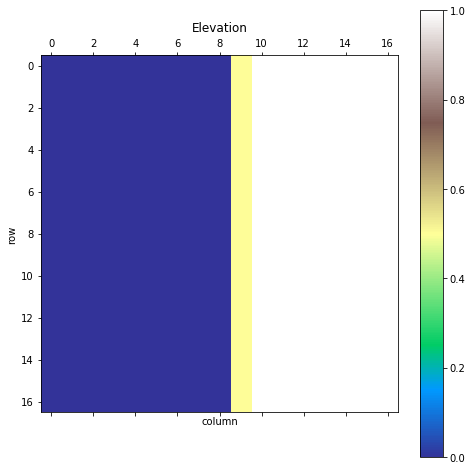

In [22]:
show_elevs(t)

To test the effectiveness of this elevation method, we can create a fire spread where fires only spread according to the outputs of our elevation funciton

In [23]:
def spread_fire_elevation(W, elevs):
    W_new = W.copy()
    Vegetation = is_unburned(W)
    Fires = is_burning(W)
    
    '''
    Add elevation effect here
    
    1) get the elevation matrix
    2) only look at the elements that border the areas on fire 
    3) add this element to the exisiting transition probabilities
    '''   
    # testing isolated effects of terrain
    fire_prob_matrix = np.zeros((W.shape[0] - 2, W.shape[1] - 2 ))
    
    elevation_effect = 1
    elev_p = elev_transition_prob(elevs)
    elev_p = elev_p[1:-1, 1:-1]
    elev_i = Vegetation[1:-1, 1:-1] \
                        & (
                              Fires[:-2, :-2]  | Fires[1:-1, :-2] | Fires[2:, :-2]
                            | Fires[:-2, 1:-1] |                    Fires[2:, 1:-1]
                            | Fires[:-2, 2:]   | Fires[1:-1, 2:]  | Fires[2:, 2:]
                           )
    
    e = np.multiply(elev_p, elev_i)
    fire_prob_matrix += e * elevation_effect
    
    # normal part 
    fire_prob_matrix = np.multiply(fire_prob_matrix, Vegetation[1:-1, 1:-1].astype(int))
        
    randys = np.random.rand(*fire_prob_matrix.shape)
    new_on_fires = randys < fire_prob_matrix
    
    W_new[1:-1, 1:-1] += new_on_fires
 
    W_new[1:-1, 1:-1] += Fires[1:-1, 1:-1]
    
    return W_new




Here, we'll create a mock world of increasing elevations and start our fire on the elevated part. As you can see, within a few time steps the fire is only spreading on the elevated part. Since the model is still probabilistic, it doesnt spread entirely evenly, however it does not spread on the flat part of the forest.

The world has dimensions: 20 x 20
There are 400 cell(s) that have had vegetation in them
There are 399 cell(s) of vegetation that are unburned
There are 1 cell(s) of vegetation on fire
There are 0 cell(s) of vegetation completely burned


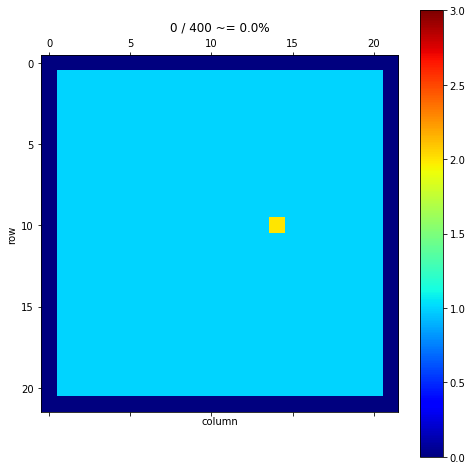

In [24]:
w = create_world(20, 1)
w = start_fire(w, [[10,14]])
e = create_increasing_elevations(w)

show_world(w)
summarize_world(w)

The world has dimensions: 20 x 20
There are 400 cell(s) that have had vegetation in them
There are 391 cell(s) of vegetation that are unburned
There are 8 cell(s) of vegetation on fire
There are 1 cell(s) of vegetation completely burned


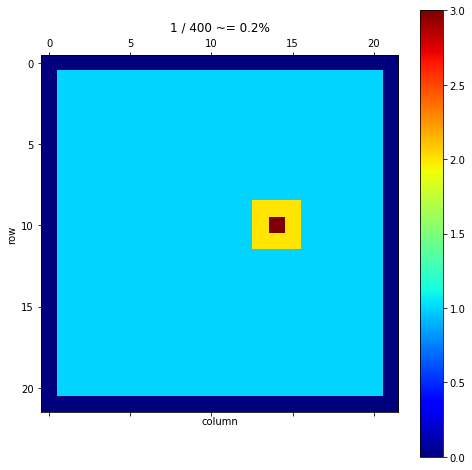

In [25]:
# step once
w = spread_fire_elevation(w, e)
show_world(w)
summarize_world(w)

The world has dimensions: 20 x 20
There are 400 cell(s) that have had vegetation in them
There are 314 cell(s) of vegetation that are unburned
There are 25 cell(s) of vegetation on fire
There are 61 cell(s) of vegetation completely burned


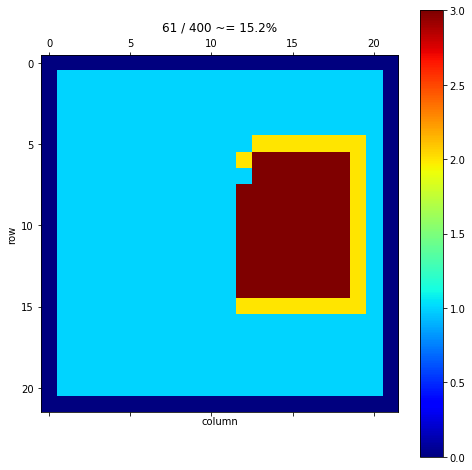

In [26]:
# step several more times to demonstrate effect 
w = spread_fire_elevation(w, e)
w = spread_fire_elevation(w, e)
w = spread_fire_elevation(w, e)
w = spread_fire_elevation(w, e)

show_world(w)
summarize_world(w)

As we can see, the fire is spreading along the gradient as reflected below.

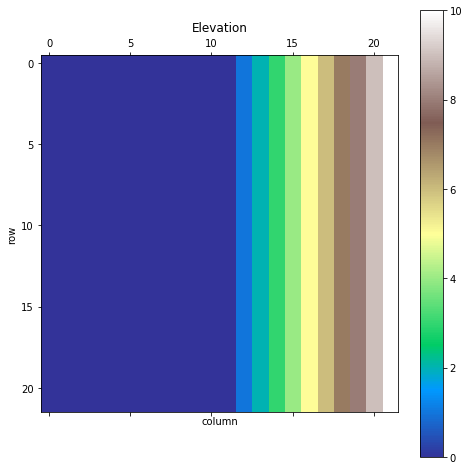

In [27]:
show_elevs(e)

Below, we combine the elevation and terrain types.

In [29]:
def spread_fire_both(W, transition_matrix, elevs):
    W_new = W.copy()
    Vegetation = is_unburned(W)
    Fires = is_burning(W)
    

    num_neighbors_on_fire = (Fires[:-2, :-2].astype(int) + Fires[1:-1, :-2] + Fires[2:, :-2] 
                             + Fires[:-2, 1:-1]                             + Fires[2:, 1:-1] 
                             + Fires[:-2, 2:]            + Fires[1:-1, 2:]  + Fires[2:, 2:])
  
    num_neighbors_on_fire = np.multiply(num_neighbors_on_fire, Vegetation[1:-1, 1:-1].astype(int))
    
    fire_prob_matrix = np.ones(num_neighbors_on_fire.shape) - transition_matrix[1:-1, 1:-1]
    
    fire_prob_matrix = 1.0 - np.power(fire_prob_matrix, num_neighbors_on_fire)
        
    elevation_effect = 1
    elev_p = elev_transition_prob(elevs)
    elev_p = elev_p[1:-1, 1:-1]
    elev_i = Vegetation[1:-1, 1:-1] \
                        & (
                              Fires[:-2, :-2]  | Fires[1:-1, :-2] | Fires[2:, :-2]
                            | Fires[:-2, 1:-1] |                    Fires[2:, 1:-1]
                            | Fires[:-2, 2:]   | Fires[1:-1, 2:]  | Fires[2:, 2:]
                           )
    
    e = np.multiply(elev_p, elev_i)
    fire_prob_matrix = .5 * fire_prob_matrix +  .5 * e * elevation_effect    
    
    # normal part 
    fire_prob_matrix = np.multiply(fire_prob_matrix, Vegetation[1:-1, 1:-1].astype(int))
        
    randys = np.random.rand(*fire_prob_matrix.shape)
    new_on_fires = randys < fire_prob_matrix
    
    W_new[1:-1, 1:-1] += new_on_fires
 
    W_new[1:-1, 1:-1] += Fires[1:-1, 1:-1]
    
    return W_new



# Testing

The world has dimensions: 5 x 5
There are 25 cell(s) that have had vegetation in them
There are 24 cell(s) of vegetation that are unburned
There are 1 cell(s) of vegetation on fire
There are 0 cell(s) of vegetation completely burned


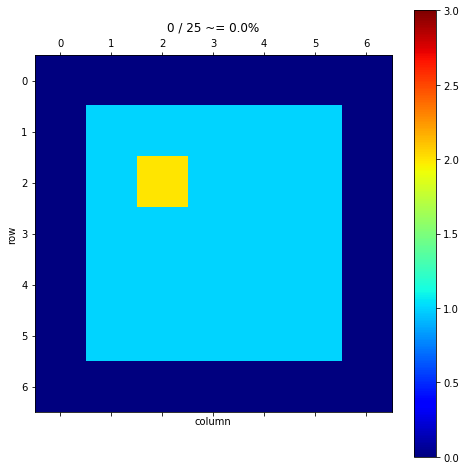

In [30]:
w = create_world(5, 1)
w = start_fire(w, [[2,2]])
tm = create_transition_matrix(w, 'M')
e = create_increasing_elevations(w)

show_world(w)
summarize_world(w)

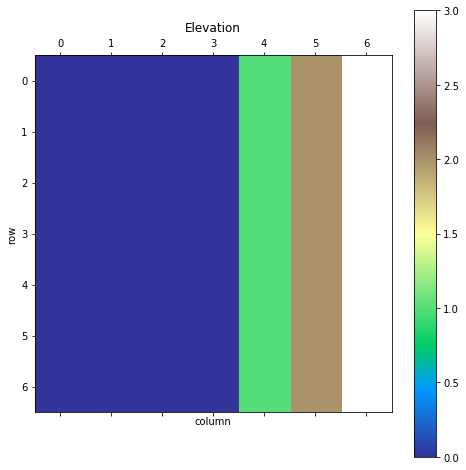

In [31]:
show_elevs(e)

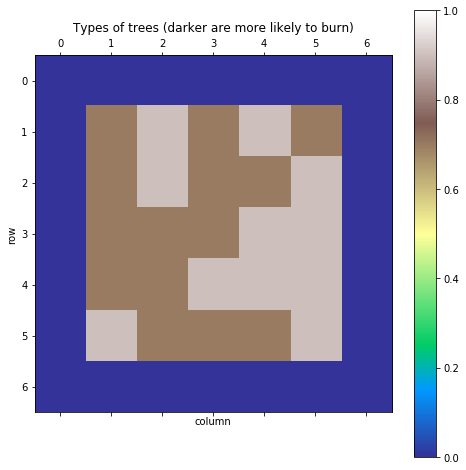

In [32]:
show_tm(np.multiply(tm, is_vegetation(w)))

The world has dimensions: 5 x 5
There are 25 cell(s) that have had vegetation in them
There are 21 cell(s) of vegetation that are unburned
There are 3 cell(s) of vegetation on fire
There are 1 cell(s) of vegetation completely burned


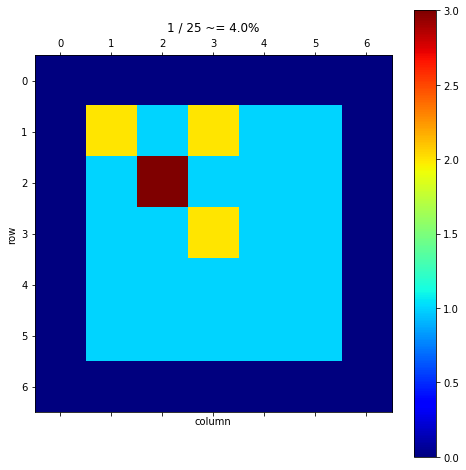

In [33]:
w = spread_fire_both(w, tm, e)
show_world(w)
summarize_world(w)

## Simulations

In [34]:
def simulate(W0, tree_type, elevs, t_max=None, inplace=False):
    if t_max is None:
        n_max = max(W0.shape)
        t_max = n_max * ((2*n_max-1) // 2)
    W = np.zeros((W0.shape[0], W0.shape[1], 2 if inplace else t_max+1))
        
    tm = create_transition_matrix(W0, tree_type)

    t_cur = 0
    W[:, :, t_cur] = W0
    for t in range(t_max):
        t_next = (t_cur+1)%2 if inplace else t+1
        W[:, :, t_next] = spread_fire_both(W[:, :, t_cur], tm, elevs)
        if (W[:, :, t_cur] == W[:, :, t_next]).all():
            t_cur = t_next
            break
        t_cur = t_next
    return (W[:, :, t_cur], t) if inplace else W[:, :, :t_cur+1]
    
def viz(W, t=0):
    show_world(W[:, :, t])
    plt.show()
    print("At time {} (max={})...".format(t, W.shape[2]-1))
    summarize_world(W[:, :, t])
    
def run_simulation(n, q, tree_type, e, **args):
    
    w = create_world(n, q)
    w = start_fire(w)
    
    return simulate(w, tree_type, e, **args)


In [35]:
def simulate_many(n, q, trials, tree_type, e, **args):
    percent_burned = np.zeros(trials)
    time_to_burn = np.zeros(trials)    

    for trial in range(trials):
        W_last, t_last = run_simulation(n, q, tree_type, e, inplace=True, **args)
        n_trees = count(W_last, is_vegetation)
        n_burnt = count(W_last, is_burned)
        percent_burned[trial] = n_burnt / n_trees if n_trees > 0 else 0.0
        time_to_burn[trial] = t_last
    return percent_burned, time_to_burn

## Analyzing effect of tree type

In [36]:
n_many = 25
tree_types = ['C', 'B', 'M']

Percentages = np.zeros((len(tree_types), 2))
Times = np.zeros((len(tree_types), 2))

e = create_increasing_elevations(np.zeros((n_many + 2, n_many + 2)))

for k, t in enumerate(tree_types):
    print("Simulating tree type:{}...".format(t))
    percentages, times = simulate_many(n_many, 1, 100, t, e)
    Percentages[k, :] = [percentages.mean(), percentages.std()]
    Times[k, :] = [times.mean(), times.std()]

Simulating tree type:C...
Simulating tree type:B...
Simulating tree type:M...


The plot below shows the fraction of trees that burn for each type, however since our forest was of density 1, each tree types is burned completley and thus this graph is not very interesting.

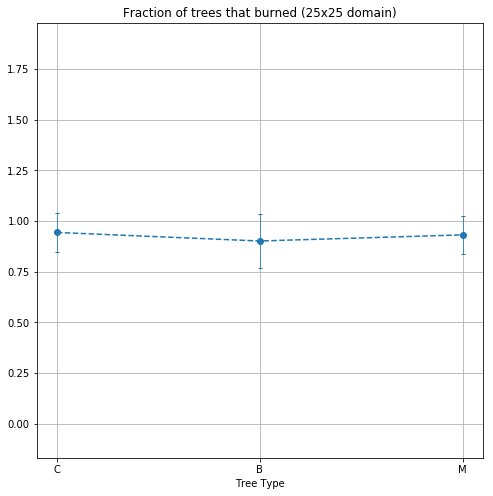

In [37]:
plt.figure(figsize=(8, 8))
plt.errorbar(tree_types, Percentages[:, 0], yerr=Percentages[:, 1], fmt='o--', elinewidth=0.75, capsize=2);
plt.gca().axis('equal')
plt.xlabel('Tree Type');
plt.title('Fraction of trees that burned ({}x{} domain)'.format(n_many, n_many));
plt.grid()

However, below we can see how the times to burn differ between the tree types. As we would expect, coniferous forests burn the fastest, broadleaf the slowest and mixed somewhere in between 

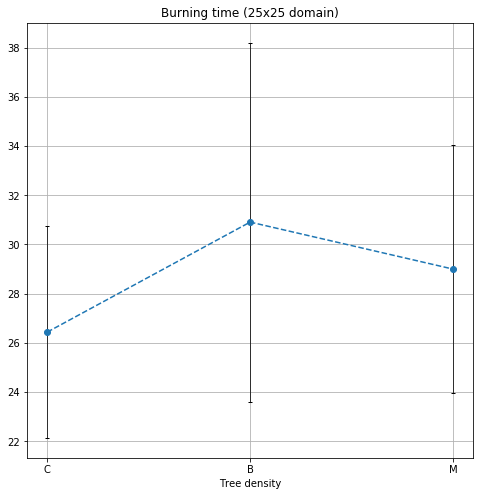

In [38]:
plt.figure(figsize=(8, 8))
Z = 1 
plt.errorbar(tree_types, Times[:, 0]/Z, yerr=Times[:, 1]/Z, fmt='o--', ecolor='black', elinewidth=0.75, capsize=2);
plt.xlabel('Tree density');
plt.title('Burning time ({}x{} domain)'.format(n_many, n_many));
plt.grid()

## Analyzing effect of elevation

In [39]:
n_many = 25

w_base = np.zeros((n_many + 2, n_many + 2))

e_raised = create_increasing_elevations(w_base)
e_flat = w_base
e_ridge = add_middle_ridge(w_base)

elevations = {'Gradient': e_raised, 'Flat': e_flat, 'Ridge': e_ridge}

e_keys = ['Gradient', 'Flat', 'Ridge']

Percentages_2 = np.zeros((len(elevations), 2))
Times_2 = np.zeros((len(elevations), 2))


for index, key in enumerate(e_keys):
    print("Simulating elevation type:{}...".format(key))
    percentages, times = simulate_many(n_many, 1, 100, 'C', elevations[key])
    Percentages_2[index, :] = [percentages.mean(), percentages.std()]
    Times_2[index, :] = [times.mean(), times.std()]

Simulating elevation type:Gradient...
Simulating elevation type:Flat...
Simulating elevation type:Ridge...


As the plot below demonstrates, the gradient elevation map where half of the map is increasing has a lower number of time steps to burn to completion than the flat. The ridge where a middle ridge of elevated height exists also has a lower number of steps than the pure flat one. Since this model is probabilistic, theses differences are subtle and more pronounced in some runs than others.

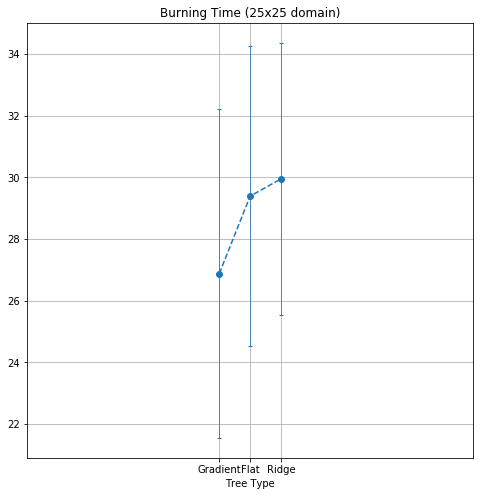

In [40]:
plt.figure(figsize=(8, 8))
plt.errorbar(e_keys, Times_2[:, 0], yerr=Times_2[:, 1], fmt='o--', elinewidth=0.75, capsize=2);
plt.gca().axis('equal')
plt.xlabel('Tree Type');
plt.title('Burning Time ({}x{} domain)'.format(n_many, n_many));
plt.grid()